In [23]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("nasdaq100_padding.csv")


In [46]:
data

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.800,97.80,61.1500,95.4000,58.180000,58.00,127.0400,26.6800,165.8100,...,70.7300,45.2300,31.1701,95.2700,81.365,52.160,33.95,48.6100,38.0100,4665.054
1,35.9310,96.890,97.80,61.6100,95.4115,58.190000,58.12,126.0600,26.7300,165.9101,...,70.6900,45.0100,31.1900,94.1700,81.540,52.150,34.10,48.7400,38.1400,4665.054
2,35.9044,96.950,97.57,61.9800,95.5100,58.203333,57.95,126.5100,26.7120,166.1800,...,71.3000,45.0150,31.2100,94.7490,81.530,52.270,34.01,48.9900,38.1500,4665.826
3,35.8900,96.970,97.55,62.0900,95.5200,58.216667,57.96,126.2800,26.7400,166.1480,...,71.3100,45.0200,31.2100,94.3100,81.710,52.300,33.96,48.9500,38.1950,4667.081
4,36.0080,96.960,97.73,61.8900,95.5300,58.230000,58.21,126.5850,26.7200,165.9900,...,71.0600,45.0500,31.1800,94.1550,81.720,52.300,34.17,48.8900,38.3200,4664.491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40555,48.5030,115.880,104.19,73.2895,102.2900,74.690000,67.39,121.1264,32.9200,146.3911,...,73.8100,34.8100,24.7550,72.1400,84.330,70.230,32.04,59.9200,38.5300,4921.811
40556,48.5150,115.875,104.18,73.2900,102.3100,74.675000,67.43,121.2000,32.9300,146.3951,...,73.8100,34.7950,24.7597,72.0928,84.340,70.220,32.03,59.9290,38.5100,4921.580
40557,48.5300,115.875,104.15,73.2850,102.3200,74.680000,67.40,121.3500,32.9064,146.3700,...,73.8001,34.7901,24.7571,72.0600,84.350,70.165,32.03,59.9345,38.5084,4921.884
40558,48.5600,115.920,104.19,73.3000,102.3100,74.750000,67.35,121.3000,32.9200,146.3400,...,73.8101,34.8200,24.7500,72.0950,84.320,70.210,32.04,59.9400,38.5050,4922.949


In [47]:

batch_size = 128
timesteps = 20
n_timeseries = data.shape[1]
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [48]:
X = np.zeros((len(data), timesteps, data.shape[1]))


In [49]:

for i, name in enumerate(list(data.columns)):
    print(name)
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

AAL
AAPL
ADBE
ADI
ADP
ADSK
AKAM
ALXN
AMAT
AMGN
AMZN
ATVI
AVGO
BBBY
BIDU
BIIB
CA
CELG
CERN
CMCSA
COST
CSCO
CSX
CTRP
CTSH
DISCA
DISH
DLTR
EA
EBAY
ESRX
EXPE
FAST
FB
FOX
FOXA
GILD
GOOGL
INTC
JD
KHC
LBTYA
LBTYK
LRCX
MAR
MAT
MCHP
MDLZ
MSFT
MU
MXIM
MYL
NCLH
NFLX
NTAP
NVDA
NXPI
PAYX
PCAR
PYPL
QCOM
QVCA
ROST
SBUX
SIRI
STX
SWKS
SYMC
TMUS
TRIP
TSCO
TSLA
TXN
VIAB
VOD
VRTX
WBA
WDC
WFM
XLNX
YHOO
NDX


In [50]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [51]:

X = X[timesteps:]
target = target[timesteps:]

In [52]:

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [53]:

X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [54]:
X_train.shape

(35100, 20, 82)

In [55]:
X_val.shape

(2730, 20, 82)

In [56]:
X_test.shape

(2730, 20, 82)

In [57]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [58]:
trainX = np.reshape(X_train, (35100,1, 20, X_train.shape[2]))
valX = np.reshape(X_val, (2730,1, 20,X_val.shape[2]))
testX = np.reshape(X_test, (2730,1,20, X_test.shape[2] ))

In [59]:
trainX.shape

(35100, 1, 20, 82)

In [17]:
from tensorflow.keras.models import *

In [37]:
first_input = Input(shape=(20,82))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/nasdaq_1d_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(X_train, target_train,validation_data=[X_val,target_val], epochs=200, verbose=1,callbacks=[cb])

Train on 35100 samples, validate on 2730 samples
Epoch 1/200
34784/35100 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00001: val_loss improved from inf to 0.00596, saving model to saved_weights/nasdaq_1d_.hdf5
35100/35100 [==============================] - 5s 152us/sample - loss: 0.0024 - val_loss: 0.0060
Epoch 2/200
34912/35100 [============================>.] - ETA: 0s - loss: 3.5398e-04
Epoch 00002: val_loss did not improve from 0.00596
35100/35100 [==============================] - 5s 136us/sample - loss: 3.5299e-04 - val_loss: 0.0066
Epoch 3/200
35008/35100 [============================>.] - ETA: 0s - loss: 2.4199e-04
Epoch 00003: val_loss improved from 0.00596 to 0.00445, saving model to saved_weights/nasdaq_1d_.hdf5
35100/35100 [==============================] - 5s 135us/sample - loss: 2.4172e-04 - val_loss: 0.0044
Epoch 4/200
34944/35100 [============================>.] - ETA: 0s - loss: 2.4921e-04
Epoch 00004: val_loss did not improve from 0.00445
35100/3510

Epoch 34/200
34720/35100 [============================>.] - ETA: 0s - loss: 6.7505e-05
Epoch 00034: val_loss did not improve from 0.00035
35100/35100 [==============================] - 5s 133us/sample - loss: 6.7419e-05 - val_loss: 0.0011
Epoch 35/200
35040/35100 [============================>.] - ETA: 0s - loss: 7.0292e-05
Epoch 00035: val_loss did not improve from 0.00035
35100/35100 [==============================] - 5s 133us/sample - loss: 7.0247e-05 - val_loss: 0.0015
Epoch 36/200
34880/35100 [============================>.] - ETA: 0s - loss: 7.3093e-05
Epoch 00036: val_loss did not improve from 0.00035
35100/35100 [==============================] - 5s 133us/sample - loss: 7.2993e-05 - val_loss: 0.0012
Epoch 37/200
34752/35100 [============================>.] - ETA: 0s - loss: 6.7627e-05
Epoch 00037: val_loss did not improve from 0.00035
35100/35100 [==============================] - 5s 133us/sample - loss: 6.7297e-05 - val_loss: 9.8690e-04
Epoch 38/200
34816/35100 [==============

Epoch 68/200
34976/35100 [============================>.] - ETA: 0s - loss: 6.1412e-05
Epoch 00068: val_loss did not improve from 0.00027
35100/35100 [==============================] - 5s 134us/sample - loss: 6.1319e-05 - val_loss: 6.9970e-04
Epoch 69/200
34688/35100 [============================>.] - ETA: 0s - loss: 6.1415e-05
Epoch 00069: val_loss did not improve from 0.00027
35100/35100 [==============================] - 5s 133us/sample - loss: 6.1234e-05 - val_loss: 4.8063e-04
Epoch 70/200
34944/35100 [============================>.] - ETA: 0s - loss: 6.2733e-05
Epoch 00070: val_loss did not improve from 0.00027
35100/35100 [==============================] - 5s 134us/sample - loss: 6.2625e-05 - val_loss: 6.7748e-04
Epoch 71/200
34944/35100 [============================>.] - ETA: 0s - loss: 6.1333e-05
Epoch 00071: val_loss did not improve from 0.00027
35100/35100 [==============================] - 5s 133us/sample - loss: 6.1388e-05 - val_loss: 0.0011
Epoch 72/200
34976/35100 [======

KeyboardInterrupt: 

In [38]:
model.load_weights("saved_weights/nasdaq_1d_.hdf5")

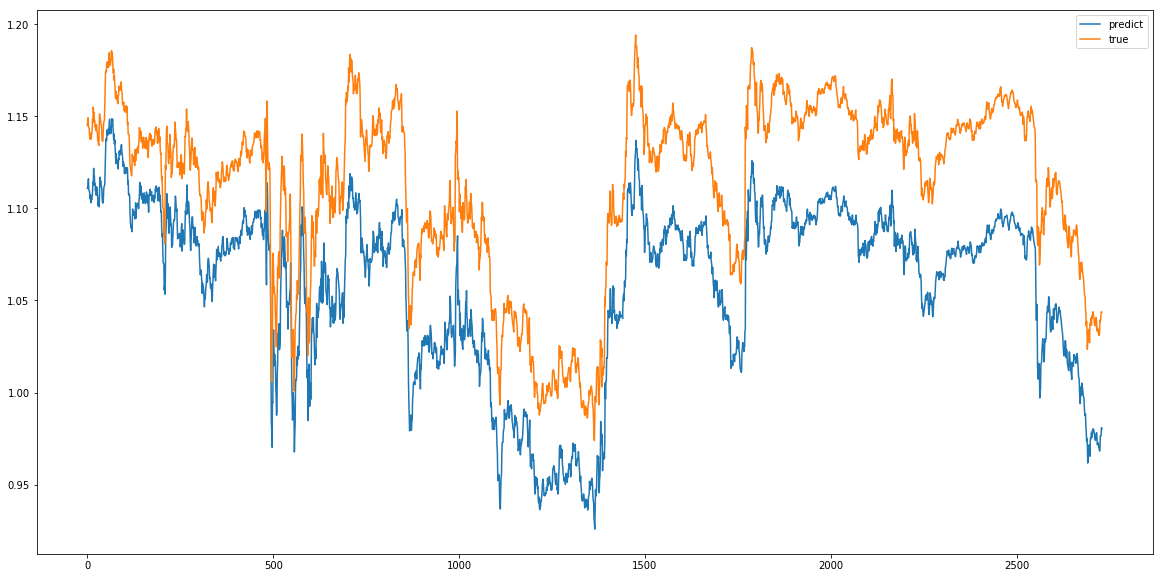

Test RMSE: 0.05570
Test MAE: 0.05447
Test MSE: 0.00310


In [41]:
from matplotlib import pyplot
from sklearn.metrics import *
yhat = model.predict([X_test])

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

In [60]:
first_input = Input(shape=(None,20,82))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=7, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')


model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 20, 82)]    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 20, 150)     139800    
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 16, 64)      48064     
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 16, 64)      4160      
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 8, 64)       0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 512)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           513 

In [61]:
checkpoint_path = "saved_weights/nas_lstmcnn_imv_2.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [65]:
history=model.fit(trainX, target_train, epochs=100, batch_size=100, validation_data=(valX, target_val), verbose=1, callbacks=[cb])

Train on 35100 samples, validate on 2730 samples
Epoch 1/100
34900/35100 [============================>.] - ETA: 0s - loss: 6.1291e-05
Epoch 00001: val_loss did not improve from 0.00050
35100/35100 [==============================] - 10s 287us/sample - loss: 6.1347e-05 - val_loss: 6.4567e-04
Epoch 2/100
34900/35100 [============================>.] - ETA: 0s - loss: 6.1072e-05
Epoch 00002: val_loss did not improve from 0.00050
35100/35100 [==============================] - 10s 288us/sample - loss: 6.0983e-05 - val_loss: 8.2936e-04
Epoch 3/100
35000/35100 [============================>.] - ETA: 0s - loss: 6.2112e-05
Epoch 00003: val_loss did not improve from 0.00050
35100/35100 [==============================] - 10s 287us/sample - loss: 6.2055e-05 - val_loss: 0.0011
Epoch 4/100
34900/35100 [============================>.] - ETA: 0s - loss: 6.6380e-05
Epoch 00004: val_loss did not improve from 0.00050
35100/35100 [==============================] - 10s 288us/sample - loss: 6.6499e-05 - val_

Epoch 35/100
35000/35100 [============================>.] - ETA: 0s - loss: 5.7473e-05
Epoch 00035: val_loss did not improve from 0.00038
35100/35100 [==============================] - 10s 285us/sample - loss: 5.7560e-05 - val_loss: 0.0014
Epoch 36/100
35000/35100 [============================>.] - ETA: 0s - loss: 5.5937e-05
Epoch 00036: val_loss did not improve from 0.00038
35100/35100 [==============================] - 10s 285us/sample - loss: 5.5910e-05 - val_loss: 0.0010
Epoch 37/100
34900/35100 [============================>.] - ETA: 0s - loss: 5.6597e-05
Epoch 00037: val_loss did not improve from 0.00038
35100/35100 [==============================] - 10s 285us/sample - loss: 5.6452e-05 - val_loss: 8.1657e-04
Epoch 38/100
35000/35100 [============================>.] - ETA: 0s - loss: 5.4165e-05
Epoch 00038: val_loss did not improve from 0.00038
35100/35100 [==============================] - 10s 285us/sample - loss: 5.4104e-05 - val_loss: 0.0011
Epoch 39/100
35000/35100 [==========

Epoch 69/100
34900/35100 [============================>.] - ETA: 0s - loss: 5.1949e-05
Epoch 00069: val_loss did not improve from 0.00038
35100/35100 [==============================] - 12s 335us/sample - loss: 5.1862e-05 - val_loss: 0.0012
Epoch 70/100
34900/35100 [============================>.] - ETA: 0s - loss: 4.9867e-05
Epoch 00070: val_loss did not improve from 0.00038
35100/35100 [==============================] - 12s 335us/sample - loss: 4.9794e-05 - val_loss: 7.6918e-04
Epoch 71/100
34900/35100 [============================>.] - ETA: 0s - loss: 5.7465e-05
Epoch 00071: val_loss did not improve from 0.00038
35100/35100 [==============================] - 12s 335us/sample - loss: 5.7424e-05 - val_loss: 0.0014
Epoch 72/100
35000/35100 [============================>.] - ETA: 0s - loss: 5.6593e-05
Epoch 00072: val_loss did not improve from 0.00038
35100/35100 [==============================] - 10s 293us/sample - loss: 5.6531e-05 - val_loss: 6.0191e-04
Epoch 73/100
34900/35100 [======

In [66]:
model.load_weights("saved_weights/nas_lstmcnn_imv_2.hdf5")

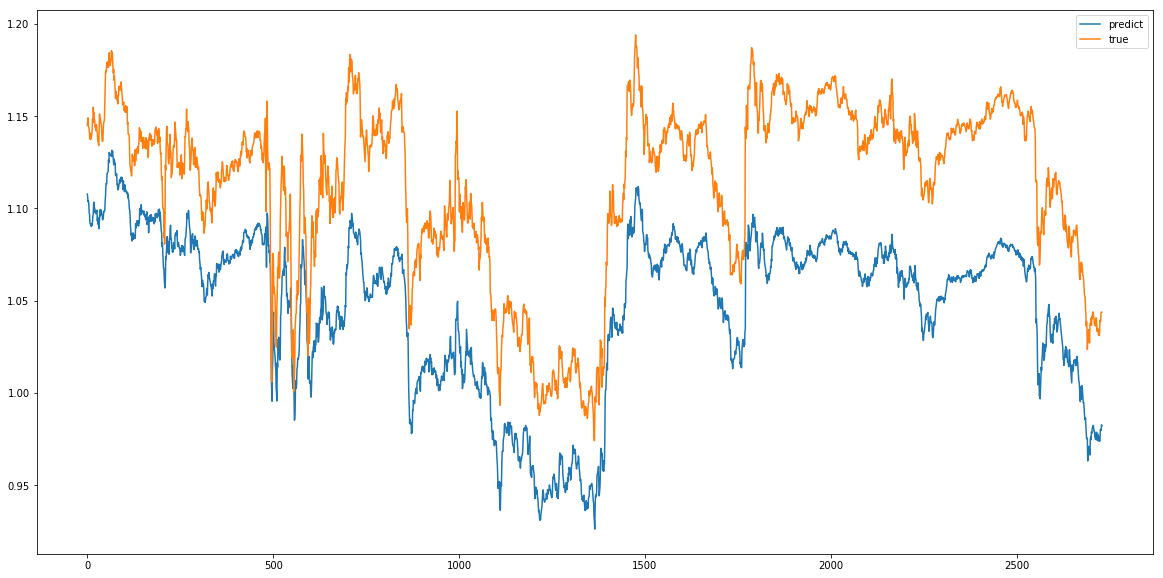

Test RMSE: 0.06684
Test MAE: 0.06497
Test MSE: 0.00447


In [67]:
from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))


pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')

pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

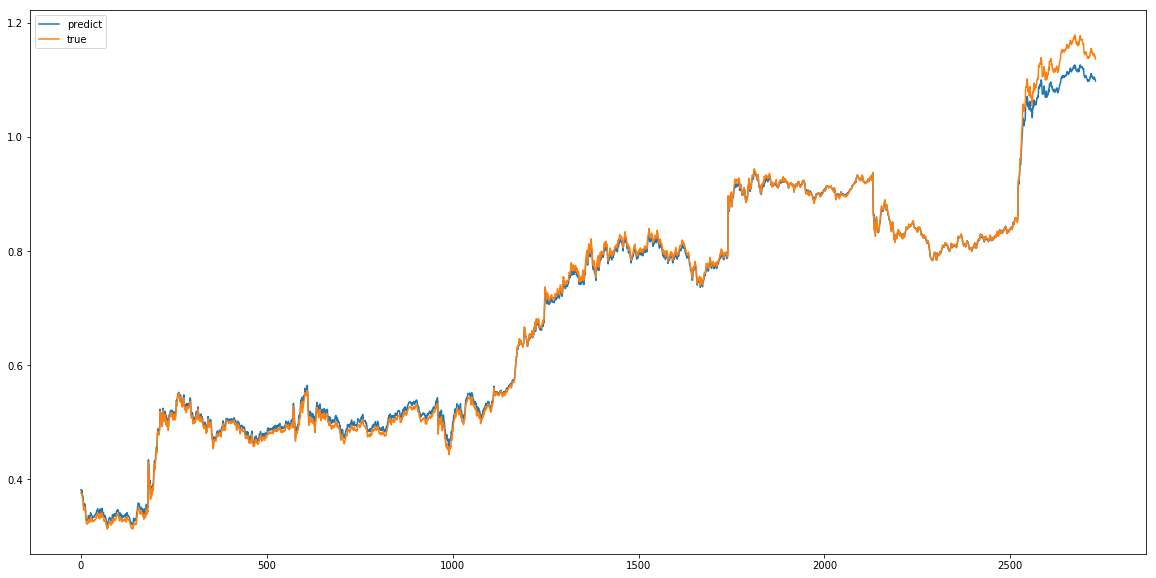

In [46]:
from matplotlib import pyplot
yhat = model.predict([valX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_val, label='true')
pyplot.legend()
pyplot.show()

In [47]:

from math import *
rmse = sqrt(mean_squared_error(target_val, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01193


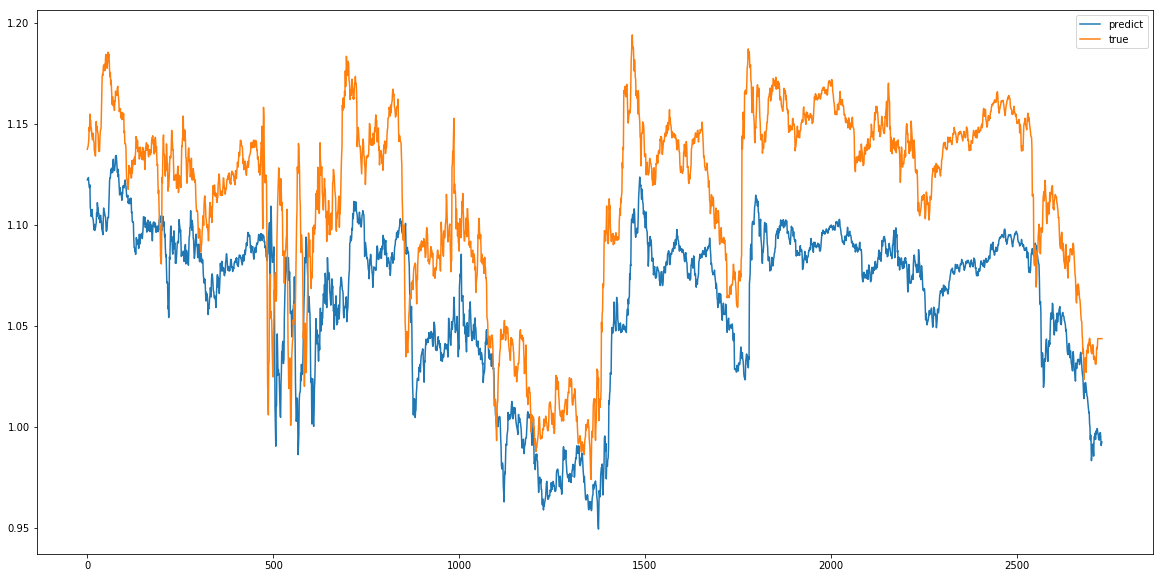

Test RMSE: 0.05545
Test MAE: 0.05072
Test MSE: 0.00307


In [48]:
from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))


pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')

pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)


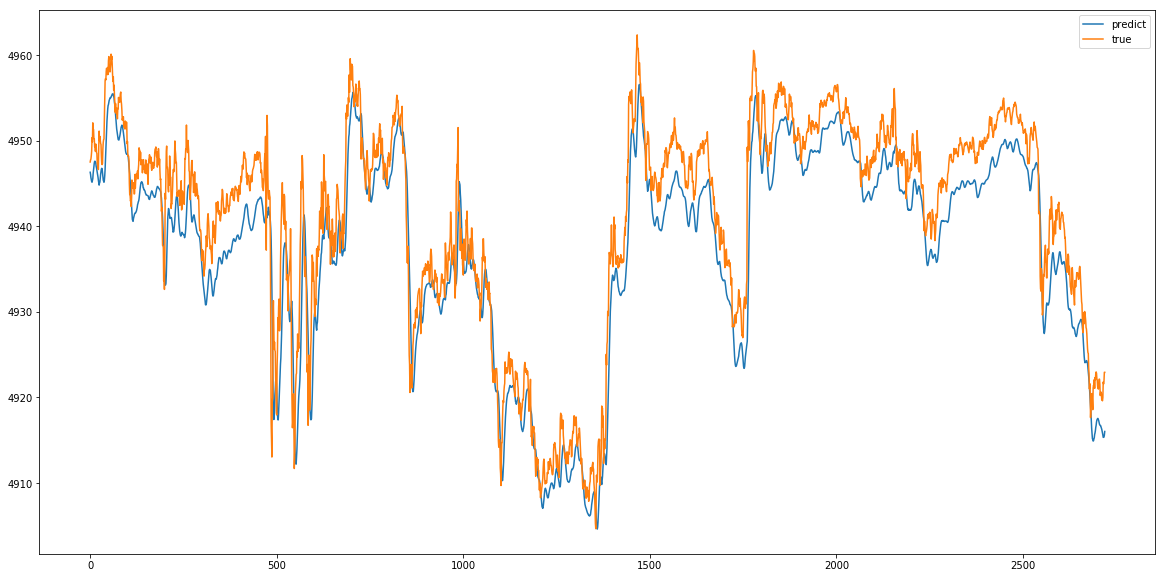

Test RMSE: 4.72999
Test MAE: 3.95179
Test MSE: 22.37284


In [208]:
from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')

pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



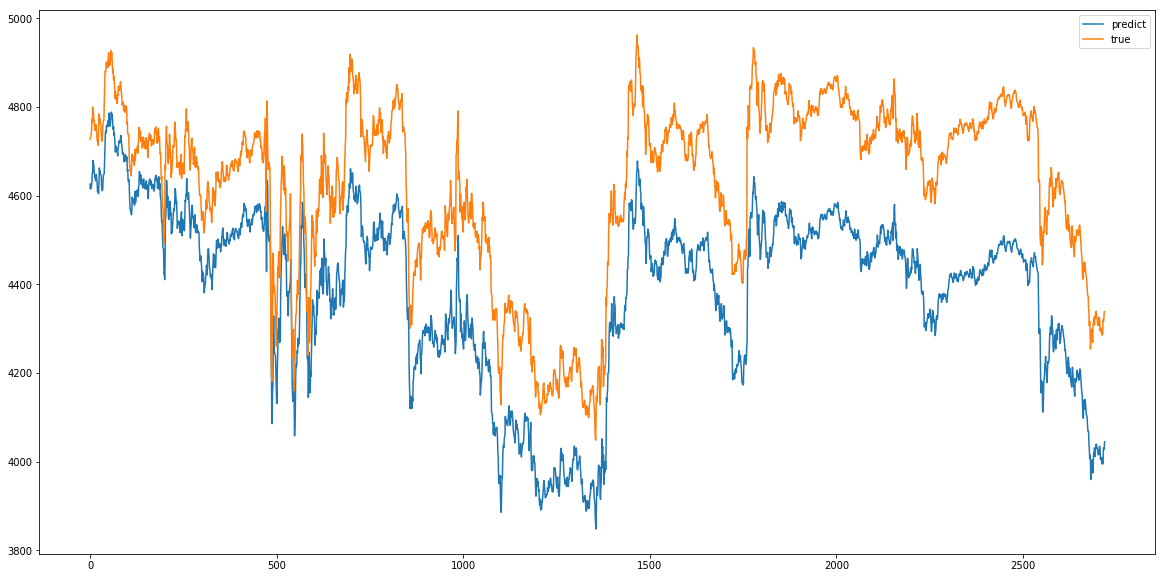

In [121]:

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')

pyplot.legend()
pyplot.show()

### attention cnn, cnn, rescnn 순서

In [45]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 2.78804


In [49]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 5.21353


In [35]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01849


In [86]:
from tensorflow.keras.models import Model


def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

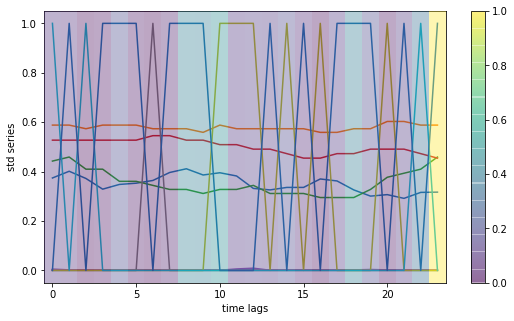

In [107]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

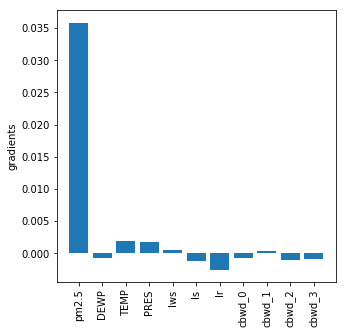

In [106]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)